# Setting

In [529]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [530]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings(action='ignore')


FONT_COLOR = "#545454"
BACKGROUND_COLOR = "#FFFCFA"

In [531]:
data_path = '/content/drive/MyDrive/DS/CO2/data/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')
country_df = pd.read_csv(data_path + 'country.csv')

train.shape, test.shape, submission.shape, country_df.shape

((79023, 76), (24353, 75), (24353, 2), (497, 3))

In [532]:
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [533]:
submission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94
1,ID_-0.510_29.290_2022_01,81.94
2,ID_-0.510_29.290_2022_02,81.94
3,ID_-0.510_29.290_2022_03,81.94
4,ID_-0.510_29.290_2022_04,81.94


In [534]:
all = pd.concat([train, test]).reset_index(drop=True)

fts = ['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no', 'emission']
all = all[fts]

all

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,emission
0,ID_-0.510_29.290_2019_00,-0.510,29.290,2019,0,3.750994
1,ID_-0.510_29.290_2019_01,-0.510,29.290,2019,1,4.025176
2,ID_-0.510_29.290_2019_02,-0.510,29.290,2019,2,4.231381
3,ID_-0.510_29.290_2019_03,-0.510,29.290,2019,3,4.305286
4,ID_-0.510_29.290_2019_04,-0.510,29.290,2019,4,4.347317
...,...,...,...,...,...,...
103371,ID_-3.299_30.301_2022_44,-3.299,30.301,2022,44,NaN
103372,ID_-3.299_30.301_2022_45,-3.299,30.301,2022,45,NaN
103373,ID_-3.299_30.301_2022_46,-3.299,30.301,2022,46,NaN
103374,ID_-3.299_30.301_2022_47,-3.299,30.301,2022,47,NaN


# EDA

## emission

In [535]:
train.emission.describe()

count    79023.000000
mean        81.940552
std        144.299648
min          0.000000
25%          9.797995
50%         45.593445
75%        109.549595
max       3167.768000
Name: emission, dtype: float64

In [536]:
df = train.groupby(['latitude', 'longitude']).emission.mean().sort_values().reset_index()
df.emission.describe()

count     497.000000
mean       81.940552
std       137.357720
min         0.000000
25%        10.900797
50%        46.700873
75%       113.135679
max      2233.431628
Name: emission, dtype: float64

In [537]:
df

,latitude,longitude,emission
0,-1.682,29.218,0.000000
1,-2.859,29.041,0.000000
2,-1.833,28.467,0.000000
3,-2.841,29.159,0.000000
4,-1.974,28.526,0.000000
...,...,...,...
492,-1.342,31.358,409.606870
493,-0.956,30.744,455.398039
494,-1.346,31.254,475.289138
495,-2.079,29.321,1221.886518


In [538]:
df[df.emission<0.1]

,latitude,longitude,emission
0,-1.682,29.218,0.000000
1,-2.859,29.041,0.000000
2,-1.833,28.467,0.000000
3,-2.841,29.159,0.000000
4,-1.974,28.526,0.000000
5,-1.730,28.470,0.000000
6,-1.712,28.688,0.000000
7,-1.696,28.304,0.000000
8,-2.817,29.283,0.000000
9,-1.839,28.761,0.000000


In [539]:
df[df.emission>300]

,latitude,longitude,emission
480,-1.048,30.252,302.324454
481,-2.300,29.200,305.690542
482,-2.376,29.924,308.460022
483,-1.641,31.259,308.698319
484,-1.486,29.614,312.098334
485,-1.187,31.113,318.536348
486,-1.115,30.085,321.410481
487,-1.889,29.611,324.808862
488,-2.293,29.507,336.199968
489,-1.847,30.953,347.017595


In [540]:
ems0_df = df[df.emission==0]
ems400_df = df[df.emission>=400]

ems0_df.shape, ems400_df.shape

((15, 3), (5, 3))

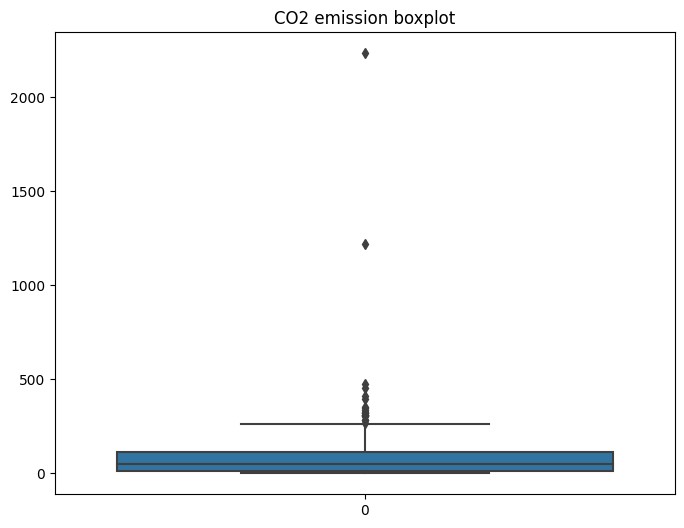

In [541]:
plt.figure(figsize=(8,6))
plt.title('CO2 emission boxplot')
sns.boxplot(df.emission)
plt.show()

In [542]:
# fig = go.Figure(go.Histogram(
#     x=train.emission,
#     marker_color='seagreen'))

# fig.update_layout(
#     title_text="CO2 Emission Distributions",
#     template='plotly_dark')

# fig.show()

In [543]:
# fig = go.Figure(go.Histogram(
#     x=np.log(train.emission),
#     marker_color='seagreen'))

# fig.update_layout(
#     title_text="CO2 Emission Distributions",
#     template='plotly_dark')

# fig.show()

## latitude & longitude

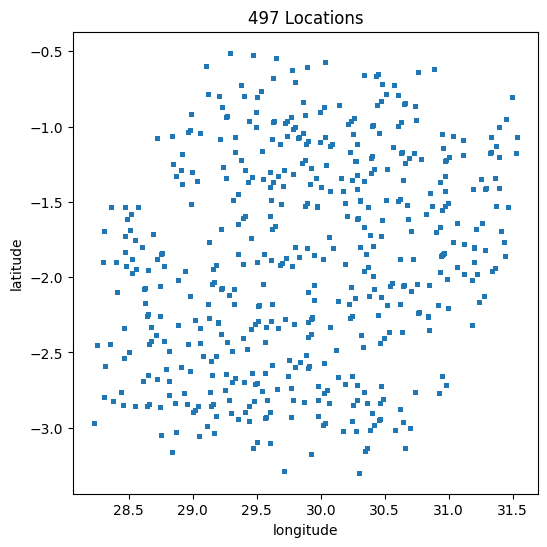

In [544]:
plt.figure(figsize=(6,6))
plt.title("497 Locations")
plt.scatter(train.longitude, train.latitude, s=5)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [545]:
marker_df = country_df.copy()

fig = px.scatter_mapbox(marker_df,
    lat="latitude",
    lon="longitude",
    color="country",
    color_discrete_map={
        'Rwanda': 'red',
        'Uganda': 'orange',
        'Tanzania': 'magenta',
        'Burundi': 'green',
        'Congo': 'blue'},
    hover_name="country",
    zoom=7,
    title="CO\u2082 Emissions by Country")

fig.update_layout(
    mapbox_style = "open-street-map",
    margin=dict(r=0, t=50, l=0, b=0),
    font_color=FONT_COLOR,
    title_font_size=18,
    mapbox_center={"lat": marker_df["latitude"].mean(), "lon": marker_df["longitude"].mean()},
    width=800,
    height=600,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR
)
fig.show()

In [546]:
emission_df = train.groupby(['latitude', 'longitude']).emission.mean().reset_index()

fig = px.scatter_mapbox(emission_df,
    lat="latitude",
    lon="longitude",
    color="emission",
    size="emission",
    color_continuous_scale='Viridis',
    size_max=20,
    zoom=7,
    width=800,
    height=600,
    title="CO\u2082 Emissions in Rwanda Area"
)

fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(r=0, t=50, l=0, b=0),
    # font_color=FONT_COLOR,
    # title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()

In [547]:
fig = px.scatter_mapbox(
    train, lat='latitude', lon='longitude',
    size='emission',
    color='emission',
    color_continuous_scale='Viridis',
    animation_frame = 'week_no',
    zoom=7)

fig.update_layout(
    title='CO2 Emission by Week',
    mapbox_style = "open-street-map",
    width=800,
    height=600)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [548]:
# marker_df = ems0_df.copy()

# fig = px.scatter_mapbox(marker_df,
#     lat="latitude",
#     lon="longitude",
#     hover_name="emission",
#     zoom=7,
#     title="Emission-Zero")

# fig.add_scattermapbox(
#     lat=ems0_df.latitude,
#     lon=ems0_df.longitude,
#     name="Emission 0",
#     marker=dict(color="Blue", size=8, symbol="circle", opacity=0.75),
# )

# fig.add_scattermapbox(
#     lat=ems400_df.latitude,
#     lon=ems400_df.longitude,
#     name="Emission Top 5",
#     marker=dict(color="Red", size=10, symbol="circle", opacity=0.75),
# )

# # fig.add_scattermapbox(
# #     lat=-1.519167,
# #     lon=29.254167,,
# #     name="Emission Top 5",
# #     marker=dict(color="Red", size=10, symbol="circle", opacity=0.75),
# # )

# fig.update_layout(
#     mapbox_style = "open-street-map",
#     margin=dict(r=0, t=50, l=0, b=0),
#     font_color=FONT_COLOR,
#     title_font_size=18,
#     mapbox_center={"lat": marker_df["latitude"].mean(), "lon": marker_df["longitude"].mean()},
#     width=800,
#     height=600,
#     plot_bgcolor=BACKGROUND_COLOR,
#     paper_bgcolor=BACKGROUND_COLOR
# )
# fig.show()

In [549]:
#  ems_0 = emission_df[emission_df.emission==0]

# fig = px.scatter_mapbox(ems_0,
#     lat='latitude',
#     lon='longitude',
#     hover_name='emission',
#     marker=dict(color='Blue', size=10, symbol="circle", opacity=0.75),
#     zoom=7)

# fig.add_scattermapbox(
#     lat=zero_emission.Latitude,
#     lon=zero_emission.Longitude,
#     name="Zero-Emission",
#     marker=dict(color="#E04C5F", size=15, symbol="circle", opacity=0.75),
# )

# # fig = px.scatter_mapbox(ems_0,
# #     lat='latitude',
# #     lon='longitude',
# #     hover_name="some_column_name")
# # #    name="Emission_0",
# #     marker=dict(color='Blue', size=10, symbol="circle", opacity=0.75),
# # )

# # fig = px.scatter_mapbox(ems_0,
# #     lat="latitude",
# #     lon="longitude",
# #     color='Blue',
# #     size=10,
# #     color_continuous_scale='Viridis',
# #     size_max=20,
# #     zoom=7,
# #     width=800,
# #     height=600,
# #     title="CO\u2082 Emissions Zero"
# # )

# fig.update_layout(
#     mapbox_style="open-street-map",
#     margin=dict(r=0, t=90, l=0, b=0),
#     font_color=FONT_COLOR,
#     title_font_size=18,
#     legend=dict(yanchor="bottom", xanchor="right", y=1, x=1, orientation="h"),
#     plot_bgcolor=BACKGROUND_COLOR,
#     paper_bgcolor=BACKGROUND_COLOR,
# )
# fig.show()

## year & week_no

In [550]:
def graph_emission_by_time(df, time):
    fig = go.Figure()

    ems = df.groupby(['year', time]).emission.mean()
    years = [2019, 2020, 2021]
    colors = ['Green', 'Red', 'Yellow']

    for year, color in zip(years, colors):
        fig.add_trace(go.Scatter(
            x=ems.loc[year].index.astype('str'),
            y=ems.loc[year],
            mode='lines',
            name=f'CO2 Emission in {year}',
            line=dict(color=color)))

    fig.update_layout(
        title_text='Average CO2 Emissions across Year',
        template='plotly_dark')

    fig.show()

In [551]:
fig = make_subplots(rows=1, cols=2)

year_cnt = all.year.value_counts()
week_cnt = all.week_no.value_counts()

fig.add_trace(go.Bar(
    x=year_cnt.index,
    y=year_cnt.values,
    text=year_cnt.values,
    name='Year',
    marker_color='seagreen'),
    row=1, col=1)

fig.add_trace(go.Bar(
    x=week_cnt.index,
    y=week_cnt.values,
    text=week_cnt.values,
    name='Week Number',
    marker_color='#378025'),
    row=1, col=2)

fig.update_layout(
    title='Counts of Year and Week Number',
    template='plotly_dark')

fig.show()

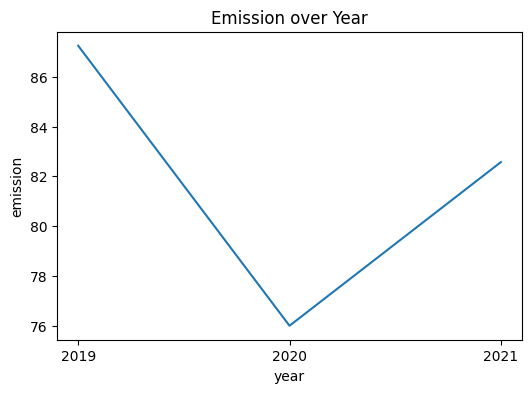

In [552]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(6, 4))
plt.title('Emission over Year')
sns.lineplot(x='year', y='emission', data=train, errorbar=None)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

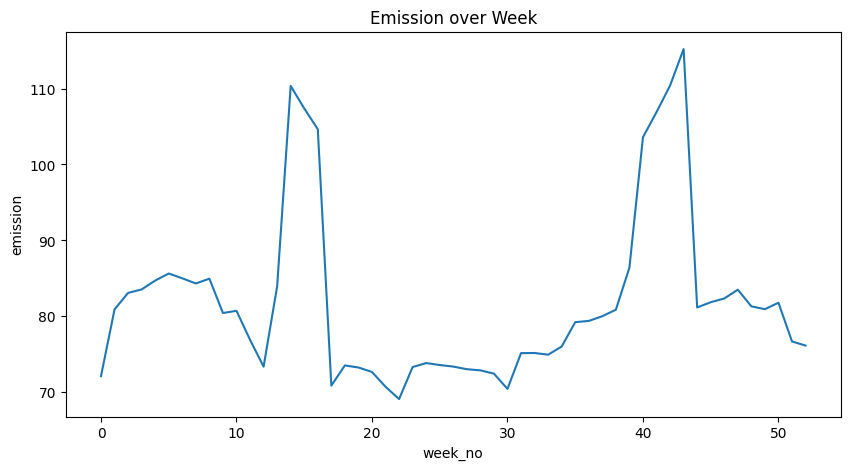

In [553]:
plt.figure(figsize=(10,5))
plt.title('Emission over Week')
sns.lineplot(x='week_no', y='emission', data=train, errorbar=None)
plt.show()

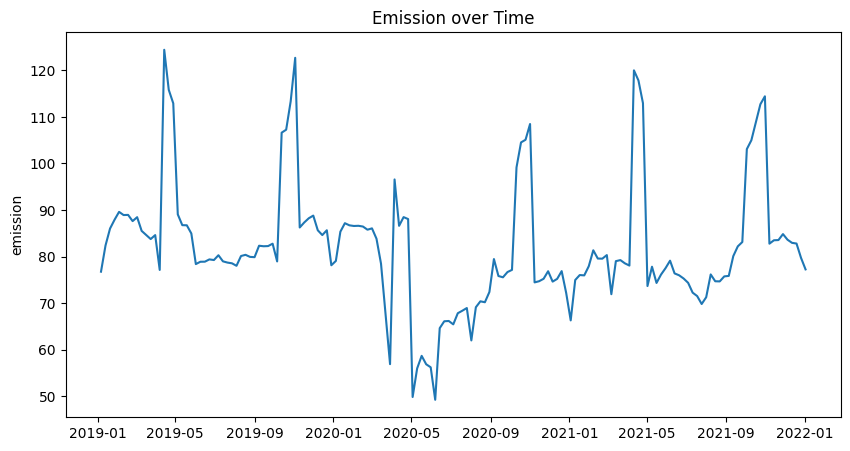

In [554]:
year_week = pd.to_datetime((train.year * 100 + train.week_no).astype('str') + '0', format='%Y%W%w')

plt.figure(figsize=(10,5))
plt.title('Emission over Time')
sns.lineplot(x=year_week, y='emission', data=train, errorbar=None)

plt.show()

In [555]:
graph_emission_by_time(train, train.week_no)

In [556]:
# plt.figure(figsize=(10, 5))
# plt.title('Time series for every location')

# unique_locations = train[['latitude', 'longitude']].drop_duplicates()
# for _, ll in unique_locations.iterrows():
#     val = train[(train.latitude==ll.latitude) & (train.longitude==ll.longitude)].emission
#     sns.lineplot(x=range(len(val)), y=val)
# for week in [0, 53, 106, 159]:
#     plt.axvline(week, color='k', linestyle='--')

# plt.xlabel('week')
# plt.ylabel('emission')
# plt.show()

In [557]:
# plt.figure(figsize=(10, 5))
# plt.title('Time series for every location')

# excluded = [
#     {'latitude': -2.378, 'longitude': 29.222},
#     {'latitude': -2.079, 'longitude': 29.321}
# ]

# unique_locations = train[['latitude', 'longitude']].drop_duplicates()
# for _, ll in unique_locations.iterrows():
#     if {'latitude': ll.latitude, 'longitude': ll.longitude} not in excluded:
#         val = train[(train.latitude==ll.latitude) & (train.longitude==ll.longitude)].emission
#         sns.lineplot(x=range(len(val)), y=val)
# for week in [0, 53, 106, 159]:
#     plt.axvline(week, color='k', linestyle='--')

# plt.xlabel('week')
# plt.ylabel('emission')
# plt.show()

# Features

## month, weekth

In [558]:
# all['month'] = pd.to_datetime((all.year * 100 + all.week_no).astype('str') + '0', format='%Y%W%w').dt.month
# all.loc[all.week_no==52, 'month'] = 12

In [559]:
all['weekth'] = (all.year-2019) * 53 + all.week_no

## country

In [560]:
all = all.merge(country_df, on=['latitude', 'longitude'], how='left')
all.country = all.country.astype('category')
all

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,emission,weekth,country
0,ID_-0.510_29.290_2019_00,-0.510,29.290,2019,0,3.750994,0,Congo
1,ID_-0.510_29.290_2019_01,-0.510,29.290,2019,1,4.025176,1,Congo
2,ID_-0.510_29.290_2019_02,-0.510,29.290,2019,2,4.231381,2,Congo
3,ID_-0.510_29.290_2019_03,-0.510,29.290,2019,3,4.305286,3,Congo
4,ID_-0.510_29.290_2019_04,-0.510,29.290,2019,4,4.347317,4,Congo
...,...,...,...,...,...,...,...,...
103371,ID_-3.299_30.301_2022_44,-3.299,30.301,2022,44,NaN,203,Burundi
103372,ID_-3.299_30.301_2022_45,-3.299,30.301,2022,45,NaN,204,Burundi
103373,ID_-3.299_30.301_2022_46,-3.299,30.301,2022,46,NaN,205,Burundi
103374,ID_-3.299_30.301_2022_47,-3.299,30.301,2022,47,NaN,206,Burundi


In [561]:
all.groupby('country')['latitude', 'longitude'].apply(lambda x: x.drop_duplicates().shape[0])

country
Burundi      65
Congo       123
Rwanda      159
Tanzania     81
Uganda       69
dtype: int64

In [562]:
all.groupby('country').emission.mean()

country
Burundi      50.027305
Congo        14.882282
Rwanda      139.004677
Tanzania     88.485920
Uganda       92.363124
Name: emission, dtype: float64

## loc_group

In [563]:
all['loc_group'] = 'Normal'

all.loc[(all.latitude==-2.079) & (all.longitude==29.321), 'loc_group'] = 'Power'
all.loc[(all.latitude==-2.378) & (all.longitude==29.222), 'loc_group'] = 'Coffee'

In [564]:
mask = all.latitude.isin(ems0_df.latitude) & all.longitude.isin(ems0_df.longitude)
all.loc[mask, 'loc_group'] = 'EMS_0'

all[all.loc_group=='EMS_0']

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,emission,weekth,country,loc_group
20511,ID_-1.328_28.872_2019_00,-1.328,28.872,2019,0,0.0,0,Congo,EMS_0
20512,ID_-1.328_28.872_2019_01,-1.328,28.872,2019,1,0.0,1,Congo,EMS_0
20513,ID_-1.328_28.872_2019_02,-1.328,28.872,2019,2,0.0,2,Congo,EMS_0
20514,ID_-1.328_28.872_2019_03,-1.328,28.872,2019,3,0.0,3,Congo,EMS_0
20515,ID_-1.328_28.872_2019_04,-1.328,28.872,2019,4,0.0,4,Congo,EMS_0
...,...,...,...,...,...,...,...,...,...
101509,ID_-2.898_29.002_2022_44,-2.898,29.002,2022,44,NaN,203,Congo,EMS_0
101510,ID_-2.898_29.002_2022_45,-2.898,29.002,2022,45,NaN,204,Congo,EMS_0
101511,ID_-2.898_29.002_2022_46,-2.898,29.002,2022,46,NaN,205,Congo,EMS_0
101512,ID_-2.898_29.002_2022_47,-2.898,29.002,2022,47,NaN,206,Congo,EMS_0


## emission

In [565]:
df = train.groupby(['latitude', 'longitude'])['emission'].mean().reset_index()
df.columns = ['latitude', 'longitude', 'loc_avg_all']
all = pd.merge(all, df, on=['latitude', 'longitude'], how='left')

df
#all

,latitude,longitude,loc_avg_all
0,-3.299,30.301,27.633301
1,-3.287,29.713,42.077684
2,-3.174,29.926,44.832340
3,-3.161,28.839,0.125809
4,-3.153,30.347,14.502592
...,...,...,...
492,-0.598,29.102,0.090357
493,-0.569,30.031,116.187763
494,-0.547,29.653,0.589954
495,-0.528,29.472,4.183500


In [566]:
df = train.groupby(['latitude', 'longitude', 'week_no'])['emission'].max().reset_index()
df.columns = ['latitude', 'longitude', 'week_no', 'loc_max_week']
all = pd.merge(all, df, on=['latitude', 'longitude', 'week_no'], how='left')

df
#all

,latitude,longitude,week_no,loc_max_week
0,-3.299,30.301,0,26.789497
1,-3.299,30.301,1,29.035374
2,-3.299,30.301,2,29.652285
3,-3.299,30.301,3,29.950650
4,-3.299,30.301,4,30.572742
...,...,...,...,...
26336,-0.510,29.290,48,4.736880
26337,-0.510,29.290,49,4.687898
26338,-0.510,29.290,50,4.607418
26339,-0.510,29.290,51,4.470275


In [567]:
# all['loc_prv'] = all.groupby('year')['loc_cur'].shift()
# all['loc_nxt'] = all.groupby('year')['loc_cur'].shift(-1)
# all['loc_max'] = all[['loc_cur', 'loc_prv', 'loc_nxt']].max(axis=1)

# all

## Covid

In [568]:
# df = train.pivot_table(index='week_no', columns='year', values='emission', aggfunc='mean')
# df.columns = ['yr{}'.format(col % 100) for col in df.columns]
# df

In [569]:
# df['cmp19-20'] = (df.yr19 - df.yr20) / df.yr19 * 100
# df['cmp20-21'] = (df.yr20 - df.yr21) / df.yr20 * 100
# df['cmp19-21'] = (df.yr19 - df.yr21) / df.yr19 * 100

# df

In [570]:
# all['is_covid'] = 0
# all.loc[(all.year==2020) & (all.week_no>=10), 'is_covid'] = 1
# all.loc[(all.year==2021) & (all.week_no<=20), 'is_covid'] = 1

# EDA

 ## Normal (480 Locations)

In [571]:
all_n = all[all.loc_group=='Normal']

<Axes: >

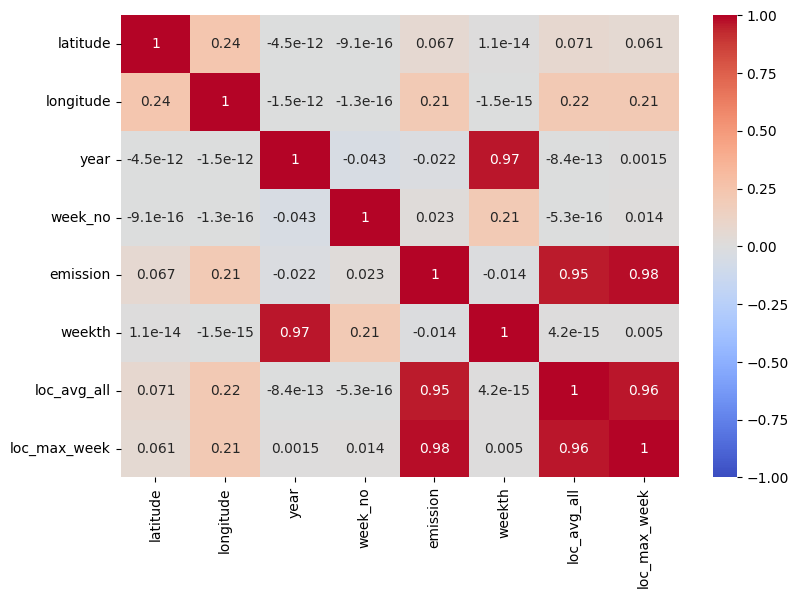

In [572]:
plt.figure(figsize=(9,6))
corr = all_n.corr()
sns.heatmap(corr, vmax=1, vmin=-1, center=0, annot=True, cmap='coolwarm')

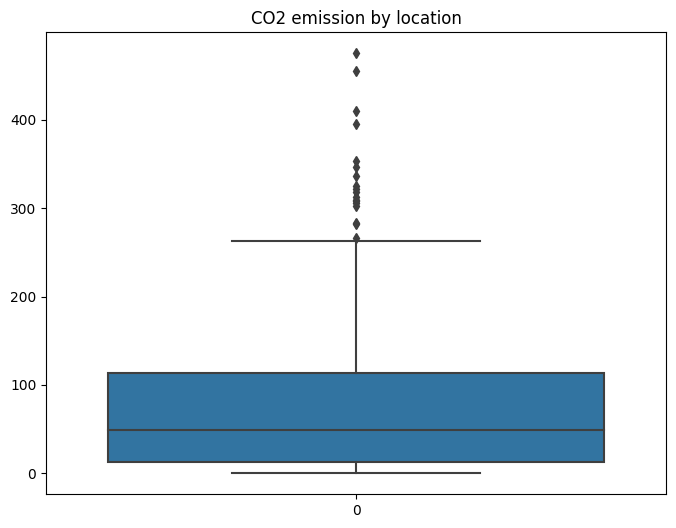

In [573]:
df = all_n.groupby(['latitude', 'longitude']).emission.mean().reset_index()

plt.figure(figsize=(8,6))
plt.title('CO2 emission by location')
sns.boxplot(df.emission)
plt.show()

In [574]:
graph_emission_by_time(all_n, all_n.week_no)

In [575]:
month = pd.to_datetime((all_n.year * 100 + all_n.week_no).astype('str') + '0', format='%Y%W%w').dt.month
graph_emission_by_time(all_n, month)

In [576]:
fig = go.Figure()

countries = ['Rwanda', 'Uganda', 'Tanzania', 'Burundi', 'Congo']
colors = ['Red', 'Orange', 'Magenta', 'Green', 'LimeGreen']

for i, country in enumerate(countries):
    # if i==0:
    #     country_data = all[(all.year<2022)].groupby('weekth').emission.mean().reset_index()
    # else:
    country_data = all_n[(all_n.year<2022) & (all_n.country==country)].groupby('weekth').emission.mean().reset_index()

    fig.add_trace(go.Scatter(
        x=year_week,
        y=country_data.emission,
        mode='lines',
        name=country,
        line=dict(color=colors[i])))

fig.update_layout(
    title='Average CO2 Emissions by Country',
    template='plotly_dark')

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [577]:
fig = make_subplots(rows=3, cols=2)

countries = ['All Countries', 'Rwanda', 'Uganda', 'Tanzania', 'Burundi', 'Congo']
colors = ['Yellow', 'Red', 'Orange', 'Magenta', 'Green', 'LimeGreen']

for i, country in enumerate(countries):
    if i==0:
        country_data = all_n[(all_n.year<2022)].groupby('weekth').emission.mean().reset_index()
    else:
        country_data = all_n[(all.year<2022) & (all_n.country==country)].groupby('weekth').emission.mean().reset_index()

    fig.add_trace(go.Scatter(
        x=year_week,
        y=country_data.emission,
        mode='lines',
        name=country,
        line=dict(color=colors[i])),
        row=i//2 + 1,
        col=i%2 + 1)

fig.update_layout(
    title='Average CO2 Emissions by Country',
    template='plotly_dark')

fig.show()

Output hidden; open in https://colab.research.google.com to view.

# Modeling

## Functions

In [578]:
def separate(df):
    drop_fts = ['emission', 'ID_LAT_LON_YEAR_WEEK', 'loc_group']

    trn = df[~df.emission.isna()].reset_index(drop=True)
    tst = df[df.emission.isna()].reset_index(drop=True)

    X = trn.drop(drop_fts, axis=1)
    X_tst = tst.drop(drop_fts, axis=1)
    y = trn.emission
    print(X.shape, y.shape, X_tst.shape)

    return X, y, X_tst, trn, tst

In [579]:
def LGBM_Modeling(X, y, X_tst):
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    vld_pred = np.zeros(len(X))
    tst_pred = np.zeros(len(X_tst))

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'force_row_wise': True,
        'verbosity': -1,
        'random_state': 42,
    }

    # params = {
    #     'objective': 'regression',
    #     'metric': 'rmse',
    #     'learning_rate': 0.05,
    #     'n_estimators': 1000,
    #     'max_depth': -1,
    #     'num_leaves': study.best_params['num_leaves'],
    #     'subsample': study.best_params['subsample'],
    #     'colsample_bytree': study.best_params['colsample_bytree'],
    #     'force_row_wise': True,
    #     'verbosity': -1,
    #     'random_state': 42,
    # }

    for fold_id, (trn_idx, vld_idx) in enumerate(folds.split(X, y)):
        print('\n', '#'*40, f'Fold {fold_id+1} / Fold {folds.n_splits}', '#'*40)
        X_trn = X.loc[trn_idx]
        y_trn = y.loc[trn_idx]
        X_vld = X.loc[vld_idx]
        y_vld = y.loc[vld_idx]

        model = LGBMRegressor(**params)
        model.fit(X_trn, y_trn,
                eval_set=[(X_trn, y_trn), (X_vld, y_vld)],
#                early_stopping_rounds=100,
#                verbose=10
                )

        vld_pred[vld_idx] = model.predict(X_vld)
        tst_pred         += model.predict(X_tst) / folds.n_splits

    return vld_pred, tst_pred

In [580]:
def XGB_Modeling(X, y, X_tst):
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    vld_pred = np.zeros(len(X))
    tst_pred = np.zeros(len(X_tst))

    params = {
        'objective': 'reg:squarederror',
        'random_state': 42,
    }

    # params = {
    #     'objective': 'reg:squarederror',
    #     'tree_method': 'exact',  #exact, approx, hist
    #     'learning_rate': 0.05,
    #     'n_estimators': 1000,
    #     'max_depth': study.best_params['max_depth'],
    #     'max_leaves': study.best_params['max_leaves'],
    #     'subsample': study.best_params['subsample'],
    #     'colsample_bytree': study.best_params['colsample_bytree'],
    #     'random_state': 42
    # }

    for fold_id, (trn_idx, vld_idx) in enumerate(folds.split(X, y)):
        print('\n', '#'*40, f'Fold {fold_id+1} / Fold {folds.n_splits}', '#'*40)
        X_trn = X.loc[trn_idx]
        y_trn = y.loc[trn_idx]
        X_vld = X.loc[vld_idx]
        y_vld = y.loc[vld_idx]

        model = XGBRegressor(**params)
        model.fit(X_trn, y_trn,
                eval_set=[(X_trn, y_trn), (X_vld, y_vld)],
                eval_metric='rmse',
    #             early_stopping_rounds=100,
                 verbose=100
                )

        vld_pred[vld_idx] = model.predict(X_vld)
        tst_pred         += model.predict(X_tst) / folds.n_splits

    return vld_pred, tst_pred

In [581]:
def RF_Modeling(X, y, X_tst):
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    vld_pred = np.zeros(len(X))
    tst_pred = np.zeros(len(X_tst))

    params = {
        'random_state': 42,
    }

    # params = {
    #     'n_estimators': 1000,
    #     'max_depth': study.best_params['max_depth'],
    #     'min_samples_split': study.best_params['min_samples_split'],
    #     'min_samples_leaf': study.best_params['min_samples_leaf'],
    #     'random_state': 42
    # }

    for fold_id, (trn_idx, vld_idx) in enumerate(folds.split(X, y)):
        print('\n', '#'*40, f'Fold {fold_id+1} / Fold {folds.n_splits}', '#'*40)
        X_trn = X.loc[trn_idx]
        y_trn = y.loc[trn_idx]
        X_vld = X.loc[vld_idx]
        y_vld = y.loc[vld_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_trn, y_trn)

        vld_pred[vld_idx] = model.predict(X_vld)
        tst_pred         += model.predict(X_tst) / folds.n_splits

    return vld_pred, tst_pred

In [582]:
def calc_diffs(trn, pred):
    fts = ['latitude', 'longitude', 'year', 'week_no', 'emission']
    cmp = trn[fts]

    cmp['pred'] = pred
    cmp['diff'] = cmp.pred - cmp.emission
    cmp['diff_abs'] = cmp['diff'].abs()
    cmp['diff_sq'] = cmp['diff']**2

    sq_sum = cmp.diff_sq.sum()
    sq_cnt = cmp.diff_sq.count()
    rmse2 = np.sqrt(sq_sum / sq_cnt)

    return rmse2, sq_sum

## HP Optimization

In [583]:
pip install optuna

In [584]:
import optuna
from optuna.samplers import TPESampler

In [585]:
def tuning(trial):
    # lgbm_params = {
    #     'objective': 'regression',
    #     'metric': 'rmse',
    #     'learning_rate': 0.1,
    #     'n_estimators': 500,
    #     'max_depth': -1,
    #     'num_leaves': trial.suggest_int("num_leaves", 8, 127),
    #     'subsample': trial.suggest_float("subsample", 0.6, 1.0),
    #     "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    #     'verbosity': -1,
    #     'random_state': 42
    # }

    # xgb_params = {
    #     'objective': 'reg:squarederror',
    #     'tree_method': 'exact',   #exact, approx, hist
    #     'learning_rate': 0.1,
    #     'n_estimators': 300,
    #     'max_depth': trial.suggest_int("max_depth", 3, 12),
    #     'max_leaves': trial.suggest_int("max_leaves", 64, 1023),
    #     'subsample': trial.suggest_float("subsample", 0.6, 1.0),
    #     'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
    #     'random_state': 42
    # }

    # rf_params = {
    #     'max_depth': trial.suggest_int('max_depth', 3, 20),
    #     'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    #     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    #     'random_state': 42
    # }

    model = LGBMRegressor(**lgbm_params)
    model = XGBRegressor(**xgb_params)
    model = RandomForestRegressor(**rf_params)
    score = cross_val_score(model, X, y, scoring="neg_root_mean_squared_error")

    return score.mean()

## category type

In [586]:
# le = LabelEncoder()
# all.country = le.fit_transform(all.country)
# all.info()

In [587]:
all = pd.get_dummies(all, columns=['country'], prefix='c', drop_first=True)
all

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,emission,weekth,loc_group,loc_avg_all,loc_max_week,c_Congo,c_Rwanda,c_Tanzania,c_Uganda
0,ID_-0.510_29.290_2019_00,-0.510,29.290,2019,0,3.750994,0,Normal,4.272966,3.753601,1,0,0,0
1,ID_-0.510_29.290_2019_01,-0.510,29.290,2019,1,4.025176,1,Normal,4.272966,4.051966,1,0,0,0
2,ID_-0.510_29.290_2019_02,-0.510,29.290,2019,2,4.231381,2,Normal,4.272966,4.231381,1,0,0,0
3,ID_-0.510_29.290_2019_03,-0.510,29.290,2019,3,4.305286,3,Normal,4.272966,4.305286,1,0,0,0
4,ID_-0.510_29.290_2019_04,-0.510,29.290,2019,4,4.347317,4,Normal,4.272966,4.347317,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103371,ID_-3.299_30.301_2022_44,-3.299,30.301,2022,44,NaN,203,Normal,27.633301,30.327420,0,0,0,0
103372,ID_-3.299_30.301_2022_45,-3.299,30.301,2022,45,NaN,204,Normal,27.633301,30.811167,0,0,0,0
103373,ID_-3.299_30.301_2022_46,-3.299,30.301,2022,46,NaN,205,Normal,27.633301,31.162886,0,0,0,0
103374,ID_-3.299_30.301_2022_47,-3.299,30.301,2022,47,NaN,206,Normal,27.633301,31.439606,0,0,0,0


## Case 1: Normal

In [588]:
X, y, X_tst, trn, tst = separate(all[all.loc_group=='Normal'])

(76320, 11) (76320,) (23520, 11)


In [589]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76320 entries, 0 to 76319
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      76320 non-null  float64
 1   longitude     76320 non-null  float64
 2   year          76320 non-null  int64  
 3   week_no       76320 non-null  int64  
 4   weekth        76320 non-null  int64  
 5   loc_avg_all   76320 non-null  float64
 6   loc_max_week  76320 non-null  float64
 7   c_Congo       76320 non-null  uint8  
 8   c_Rwanda      76320 non-null  uint8  
 9   c_Tanzania    76320 non-null  uint8  
 10  c_Uganda      76320 non-null  uint8  
dtypes: float64(4), int64(3), uint8(4)
memory usage: 4.4 MB


In [590]:
X_tst.isna().sum()

latitude        0
longitude       0
year            0
week_no         0
weekth          0
loc_avg_all     0
loc_max_week    0
c_Congo         0
c_Rwanda        0
c_Tanzania      0
c_Uganda        0
dtype: int64

In [591]:
# %%time

# sampler = TPESampler(seed=42)
# study = optuna.create_study(
#     study_name="parameter_opt",
#     direction="maximize",
#     sampler=sampler
# )

# study.optimize(tuning, n_trials=10)
# #study.optimize(tuning, n_trials=10, timeout=6000)

# print("Best Score:", study.best_value)
# print(study.best_params)

In [592]:
%%time

vld_pred_NL, tst_pred_NL = LGBM_Modeling(X, y, X_tst)
vld_pred_NX, tst_pred_NX = XGB_Modeling(X, y, X_tst)
vld_pred_NR, tst_pred_NR = RF_Modeling(X, y, X_tst)


 ######################################## Fold 1 / Fold 5 ########################################

 ######################################## Fold 2 / Fold 5 ########################################

 ######################################## Fold 3 / Fold 5 ########################################

 ######################################## Fold 4 / Fold 5 ########################################

 ######################################## Fold 5 / Fold 5 ########################################

 ######################################## Fold 1 / Fold 5 ########################################
[0]	validation_0-rmse:81.91642	validation_1-rmse:82.85721
[99]	validation_0-rmse:2.98469	validation_1-rmse:4.73351

 ######################################## Fold 2 / Fold 5 ########################################
[0]	validation_0-rmse:82.27247	validation_1-rmse:81.46524
[99]	validation_0-rmse:3.03092	validation_1-rmse:4.61175

 ######################################## Fold 3 / Fold 5 ###########

In [593]:
# vld_pred_N = vld_pred_NR
# tst_pred_N = tst_pred_NR
vld_pred_N = 0.5*vld_pred_NL + 0.5*vld_pred_NR
tst_pred_N = 0.5*tst_pred_NL + 0.5*tst_pred_NR

In [594]:
rmse1 = np.sqrt(mean_squared_error(y, vld_pred_N))
print(f'rmse1: {rmse1:.5f}')

rmse2, sq_sum_N, = calc_diffs(trn, vld_pred_N)
print(f'rmse2: {rmse2:.5f}')
print(f'sq_sum: {sq_sum_N:.5f}')

rmse1: 5.33429
rmse2: 5.33429
sq_sum: 2171662.16789


In [595]:
prd_df = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': tst.ID_LAT_LON_YEAR_WEEK
})
prd_df['emission'] = tst_pred_N

sub_df = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': submission.ID_LAT_LON_YEAR_WEEK
})
sub_df = sub_df.merge(prd_df, on='ID_LAT_LON_YEAR_WEEK', how='left')

print(f'sub_df.emission counts: {sub_df.emission.count()}')

sub_df.emission counts: 23520


## Case 2: Power

In [596]:
X, y, X_tst, trn, tst = separate(all[all.loc_group=='Power'])

(159, 11) (159,) (49, 11)


In [597]:
%%time

vld_pred_PL, tst_pred_PL = LGBM_Modeling(X, y, X_tst)
vld_pred_PX, tst_pred_PX = XGB_Modeling(X, y, X_tst)
vld_pred_PR, tst_pred_PR = RF_Modeling(X, y, X_tst)


 ######################################## Fold 1 / Fold 5 ########################################

 ######################################## Fold 2 / Fold 5 ########################################

 ######################################## Fold 3 / Fold 5 ########################################

 ######################################## Fold 4 / Fold 5 ########################################

 ######################################## Fold 5 / Fold 5 ########################################

 ######################################## Fold 1 / Fold 5 ########################################
[0]	validation_0-rmse:1077.77558	validation_1-rmse:891.96225
[99]	validation_0-rmse:0.12849	validation_1-rmse:175.52295

 ######################################## Fold 2 / Fold 5 ########################################
[0]	validation_0-rmse:1066.17494	validation_1-rmse:946.48899
[99]	validation_0-rmse:0.14255	validation_1-rmse:27.84883

 ######################################## Fold 3 / Fold 5 ##

In [598]:
tmp = trn.copy()
tmp.loc[tmp.year==2021, 'emission'] *= 1.07
tst_pred_PN = tmp[tmp.week_no<49].groupby('week_no').emission.max()

In [599]:
# vld_pred_P = vld_pred_PR
# tst_pred_P = tst_pred_PR
vld_pred_P = vld_pred_PR
tst_pred_P = 0.4*tst_pred_PR + 0.6*tst_pred_PN

In [600]:
rmse1 = np.sqrt(mean_squared_error(y, vld_pred_P))
print(f'rmse1: {rmse1:.5f}')

rmse2, sq_sum_P, = calc_diffs(trn, vld_pred_P)
print(f'rmse2: {rmse2:.5f}')
print(f'sq_sum: {sq_sum_P:.5f}')

rmse1: 133.23500
rmse2: 133.23500
sq_sum: 2822498.78044


In [601]:
prd_df = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': tst.ID_LAT_LON_YEAR_WEEK
})
prd_df['emission'] = tst_pred_P

for index, row in prd_df.iterrows():
    mask = row.ID_LAT_LON_YEAR_WEEK==sub_df.ID_LAT_LON_YEAR_WEEK
    sub_df.loc[mask, 'emission'] = row.emission

print(f'sub_df.emission counts: {sub_df.emission.count()}')

sub_df.emission counts: 23569


## Case 3: Coffee

In [602]:
X, y, X_tst, trn, tst = separate(all[all.loc_group=='Coffee'])

(159, 11) (159,) (49, 11)


In [603]:
%%time

vld_pred_CL, tst_pred_CL = LGBM_Modeling(X, y, X_tst)
vld_pred_CX, tst_pred_CX = XGB_Modeling(X, y, X_tst)
vld_pred_CR, tst_pred_CR = RF_Modeling(X, y, X_tst)


 ######################################## Fold 1 / Fold 5 ########################################

 ######################################## Fold 2 / Fold 5 ########################################

 ######################################## Fold 3 / Fold 5 ########################################

 ######################################## Fold 4 / Fold 5 ########################################

 ######################################## Fold 5 / Fold 5 ########################################

 ######################################## Fold 1 / Fold 5 ########################################
[0]	validation_0-rmse:1570.73839	validation_1-rmse:1628.93153
[99]	validation_0-rmse:0.29792	validation_1-rmse:78.82887

 ######################################## Fold 2 / Fold 5 ########################################
[0]	validation_0-rmse:1583.71191	validation_1-rmse:1548.01651
[99]	validation_0-rmse:0.38155	validation_1-rmse:85.35715

 ######################################## Fold 3 / Fold 5 #

In [604]:
tmp = trn.copy()
tmp.loc[all.year==2021, 'emission'] *= 1.07
tst_pred_CN = tmp[tmp.week_no<49].groupby('week_no').emission.max()

In [605]:
# vld_pred_C = vld_pred_CR
# tst_pred_C = tst_pred_CR
vld_pred_C = vld_pred_CL
tst_pred_C = 1.0*tst_pred_CN

In [606]:
rmse1 = np.sqrt(mean_squared_error(y, vld_pred_C))
print(f'rmse1: {rmse1:.5f}')

rmse2, sq_sum_C, = calc_diffs(trn, vld_pred_C)
print(f'rmse2: {rmse2:.5f}')
print(f'sq_sum: {sq_sum_C:.5f}')

rmse1: 89.15796
rmse2: 89.15796
sq_sum: 1263913.49552


In [607]:
prd_df = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': tst.ID_LAT_LON_YEAR_WEEK
})
prd_df['emission'] = tst_pred_C

for index, row in prd_df.iterrows():
    mask = row.ID_LAT_LON_YEAR_WEEK==sub_df.ID_LAT_LON_YEAR_WEEK
    sub_df.loc[mask, 'emission'] = row.emission

print(f'sub_df.emission counts: {sub_df.emission.count()}')

sub_df.emission counts: 23618


## Case 4: EMS_0

In [608]:
sub_df.emission = sub_df.emission.fillna(0)

print(f'sub.emission counts: {sub_df.emission.count()}')
print(f'sub.emission NAN counts: {sub_df.emission.isna().sum()}')

sub.emission counts: 24353
sub.emission NAN counts: 0


## submission

In [609]:
rmse_all = np.sqrt((sq_sum_N + sq_sum_P + sq_sum_C) / train.shape[0])
print(f'RMSE(all): {rmse_all:.5f}')

RMSE(all): 8.89905


In [610]:
oupt_path = '/content/drive/MyDrive/DS/CO2/oupt/'

sub_df.emission = np.maximum(0, sub_df.emission)
sub_df.to_csv(oupt_path + 'Ensemble_1.3.csv', index=False)

sub_df

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.632366
1,ID_-0.510_29.290_2022_01,4.227810
2,ID_-0.510_29.290_2022_02,4.382336
3,ID_-0.510_29.290_2022_03,4.515998
4,ID_-0.510_29.290_2022_04,4.515350
...,...,...
24348,ID_-3.299_30.301_2022_44,29.136067
24349,ID_-3.299_30.301_2022_45,29.636183
24350,ID_-3.299_30.301_2022_46,29.643392
24351,ID_-3.299_30.301_2022_47,29.745833


# Analysis

## Feature Importance

In [611]:
# import lightgbm as lgb

# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'random_state': 42,
# }
# model = LGBMRegressor(**params)
# model.fit(X_trn, y_trn,
#           eval_set=[(X_trn, y_trn), (X_vld, y_vld)])

# lgb.plot_importance(model, importance_type='gain', title='Feature Importance: loss reduction', xlabel='', max_num_features=12)
# plt.show

# lgb.plot_importance(model, importance_type='split', title='Feature Importance: split contribution count', xlabel='', max_num_features=12)
# plt.show

## Compare Actual-Valid.

In [612]:
# fts = ['latitude', 'longitude', 'year', 'week_no', 'emission']
# cmp = trn[fts]

# cmp['pred'] = vld_pred
# cmp['diff'] = cmp.pred - cmp.emission
# cmp['diff_abs'] = cmp['diff'].abs()
# cmp['diff_sq'] = cmp['diff']**2

# sq_sum = cmp.diff_sq.sum()
# print(f'sq_sum: {sq_sum:.5f}')

# sq_cnt = cmp.diff_sq.count()
# rmse2 = np.sqrt(sq_sum / sq_cnt)
# print(f'rmse2: {rmse2:.5f}')

In [613]:
# sorted = cmp.sort_values(by='diff_sq')
# sorted

In [614]:
# df = cmp.groupby(['latitude', 'longitude']).diff_sq.sum().reset_index()
# df['ratio'] = df.diff_sq / sq_sum
# df = df.sort_values(by='ratio', ascending=False)
# df

# #print(f'sq_sum: {df.diff_sq.sum():.5f}')
# #print(f'ratio_sum: {df.ratio.sum():.5f}')

## 2 Special Locations

In [615]:
# cmp['year_week'] = pd.to_datetime((cmp.year * 100 + cmp.week_no).astype('str') + '0', format='%Y%W%w')
# cmp1 = cmp[(cmp.latitude==-2.378) & (cmp.longitude==29.222)]
# cmp2 = cmp[(cmp.latitude==-2.079) & (cmp.longitude==29.321)]

# cmp1

In [616]:
# plt.figure(figsize = (10, 5))
# plt.title('Emission over Time')
# sns.lineplot(x=year_week, y='emission', data=cmp1, label='actual')
# sns.lineplot(x=year_week, y='pred', data=cmp1, label='pred')

# plt.show()

In [617]:
# cmp1.sort_values(by='diff_abs').tail(10)

In [618]:
# plt.figure(figsize = (10, 5))
# plt.title('Emission over Time')
# sns.lineplot(x=year_week, y='emission', data=cmp2, label='actual')
# sns.lineplot(x=year_week, y='pred', data=cmp2, label='pred')

# plt.show()

In [619]:
# cmp2.sort_values(by='diff_abs').tail(10)

## 추가

In [620]:
# fig = go.Figure()

# models = ['Actual', 'LGBM', 'XGB', 'RF']
# colors = ['Yellow', 'Red', 'Orange', 'LimeGreen']

# for i, models in enumerate(countries):
#     country_data = all_n[(all_n.year<2022) & (all_n.country==country)].groupby('weekth').emission.mean().reset_index()

#     fig.add_trace(go.Scatter(
#         x=year_week,
#         y=country_data.emission,
#         mode='lines',
#         name=country,
#         line=dict(color=colors[i])))

# fig.update_layout(
#     title='Average CO2 Emissions by Country',
#     template='plotly_dark')

# fig.show()

In [621]:
# def graph_emission_by_time(df, time):
#     fig = go.Figure()

#     ems = df.groupby(['year', time]).emission.mean()
#     years = [2019, 2020, 2021]
#     colors = ['Green', 'Red', 'Yellow']

#     for year, color in zip(years, colors):
#         fig.add_trace(go.Scatter(
#             x=ems.loc[year].index.astype('str'),
#             y=ems.loc[year],
#             mode='lines',
#             name=f'CO2 Emission in {year}',
#             line=dict(color=color)))

#     fig.update_layout(
#         title_text='Average CO2 Emissions across Year',
#         template='plotly_dark')

#     fig.show()

In [622]:
# year_week = pd.to_datetime((train.year * 100 + train.week_no).astype('str') + '0', format='%Y%W%w')

# plt.figure(figsize=(10,5))
# plt.title('Emission over Time')
# sns.lineplot(x=year_week, y='emission', data=train, errorbar=None)

# plt.show()

In [623]:
# cmp = trn[['year', 'week_no']]
# yw = pd.to_datetime((cmp.year * 100 + cmp.week_no).astype('str') + '0', format='%Y%W%w')
# cmp['year_week'] = yw

# cmp['emission'] = trn.emission
# cmp['lgbm'] = vld_pred_l
# cmp['xgb'] = vld_pred_x
# cmp['rf'] = vld_pred_r

# cmp

In [624]:
# plt.figure(figsize=(10,5))
# plt.title('Emission over Time')
# sns.lineplot(x='year_week', y='emission', data=cmp, errorbar=None)
# sns.lineplot(x='year_week', y='lgbm', data=cmp, errorbar=None)
# sns.lineplot(x='year_week', y='xgb', data=cmp, errorbar=None)
# sns.lineplot(x='year_week', y='rf', data=cmp, errorbar=None)

# plt.show()

In [625]:
# import plotly.express as px
# import pandas as pd

# # Calculate the mean values by year_week
# mean_values = cmp.groupby('year_week', as_index=False).mean()

# # Create a figure
# fig = px.line(mean_values, x='year_week', y=['emission', 'lgbm', 'xgb', 'rf'])

# # Customize the figure layout
# fig.update_layout(
#     title='Average Emission over Time',
#     xaxis_title='Year Week',
#     yaxis_title='Average Value',
#     template='plotly',
#     width=800,
#     height=400
# )

# # Show the figure
# fig.show()